In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

import seaborn as sns
import keras
from vis.utils import utils
from vis.visualization import visualize_saliency
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations
from vis.input_modifiers import Jitter

Using TensorFlow backend.
/Users/imanwahle/anaconda2/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a release (2.7.7+) that supports hmac.compare_digest as soon as possible.
  utils.PersistentlyDeprecated2018,


In [8]:
# Load the model
yaml_file = open('grid_cnn_incl_spin.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = keras.models.model_from_yaml(loaded_model_yaml)

# load weights into new model
model.load_weights("/Users/imanwahle/Desktop/CS101/grid_cnn_incl_spin_weights.h5")

In [2]:
# load image data and class labels
path = "/Users/imanwahle/Desktop/CS101/"
X_data = np.load(path + "X_data.npy")
y_data = np.load(path + "y_data.npy")
X = np.zeros((X_data.shape[0], X_data.shape[1], X_data.shape[2], 1))
X[:,:,:,0] = X_data
y2d = y_data.copy()
y2d[:,0] = y_data[:,0]//20
idx = np.where(y2d[:,0]==5)[0]
y2d[idx,0] = 4
y2d[:,1] = y_data[:,1]//20
y = y2d[:,1]*5 + y2d[:,0]

/Users/imanwahle/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


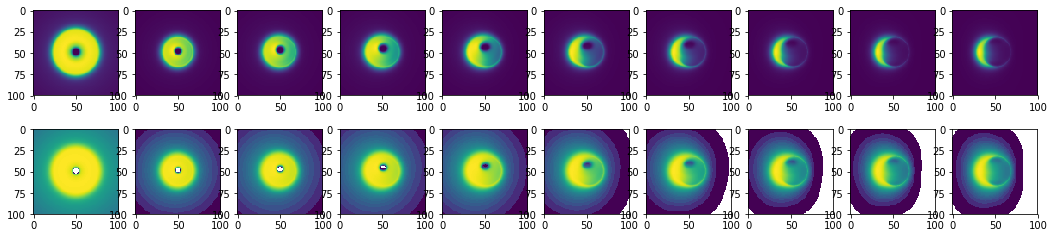

In [96]:
# Let's first check out this log-space quantization thing
fig, ax = plt.subplots(2,10,figsize=(18,4))
cnt = 0
for i in range(0,9000,900):
    data = X_data[i]
    ax[0,cnt].imshow((data).astype(float)+1)
    ax[1,cnt].imshow(np.log(data).astype(float)+1)
    # plt.colorbar()
    cnt+=1
plt.show()

So we definitely have quantization effects here! We should figure out how to mitigate this.

Alright so first we'll try just doing the bare minimum:
    - train neural net
    - switch softmax with linear activation in final layer

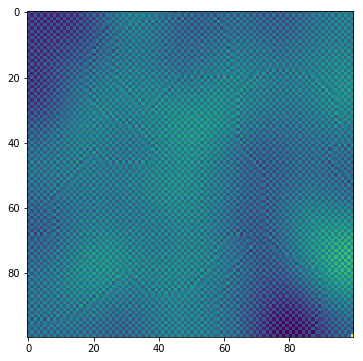

In [12]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = -1 # utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])
plt.show()

Wow this really sucks!

Alright next we'll try constraining the maximization output to (0,1)

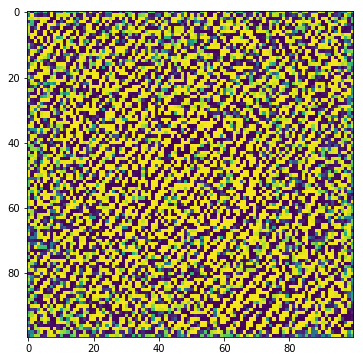

In [14]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.))
plt.imshow(img[..., 0])
plt.show()

OMG why did this fail so hard

Update: It looks like inputs to the original CNN in grid_cnn weren't scaled to (0,1) !

Let's retrain!

In [3]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import TensorBoard


# UPDATED: SCALING X_DATA TO (0,1)
X_data = X_data/np.max(X_data)
X = np.zeros((X_data.shape[0], X_data.shape[1], X_data.shape[2], 1))
X[:,:,:,0] = X_data
n_classes = len(np.unique(y))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# one hot
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

# model definition
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(100,100,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

# training
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy', 'mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               18874496  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [4]:
batch_size = 32
epochs = 20
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[TensorBoard(log_dir='/tmp/cnn3')])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# to see loss plot run this in terminal: tensorboard --logdir=/tmp/cnn1

Train on 6817 samples, validate on 2273 samples
Epoch 1/20
6817/6817 [==============================] - 380s 56ms/step - loss: 1.3801 - acc: 0.5373 - mean_squared_error: 0.0240 - val_loss: 0.8234 - val_acc: 0.6824 - val_mean_squared_error: 0.0172
Epoch 2/20
6817/6817 [==============================] - 371s 54ms/step - loss: 0.8552 - acc: 0.6670 - mean_squared_error: 0.0178 - val_loss: 0.7248 - val_acc: 0.6995 - val_mean_squared_error: 0.0159
Epoch 3/20
6817/6817 [==============================] - 371s 54ms/step - loss: 0.7835 - acc: 0.6833 - mean_squared_error: 0.0167 - val_loss: 0.6923 - val_acc: 0.7052 - val_mean_squared_error: 0.0152
Epoch 4/20
6817/6817 [==============================] - 371s 54ms/step - loss: 0.7393 - acc: 0.6949 - mean_squared_error: 0.0159 - val_loss: 0.6741 - val_acc: 0.7184 - val_mean_squared_error: 0.0150
Epoch 5/20
6817/6817 [==============================] - 370s 54ms/step - loss: 0.7095 - acc: 0.7094 - mean_squared_error: 0.0153 - val_loss: 0.6514 - val_ac

Now we've normalized the input and trained for 20 instead of 10 epochs.
Here's a maximized image without constrained input

Instructions for updating:
dim is deprecated, use axis instead


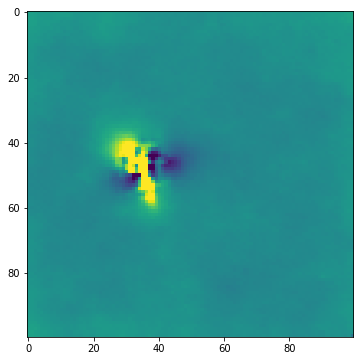

In [5]:
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = -1 # utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])
plt.show()

l o l what does this mean

Here's the constrained (0,1) input version

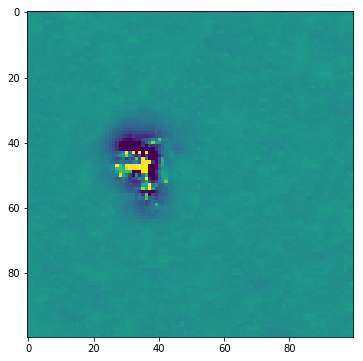

In [6]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.))
plt.imshow(img[..., 0])
plt.show()

Ok these maybe make more sense not really?? Let's see if the regularizers are overpowering our maximization loss term

Iteration: 1, named_losses: [('ActivationMax Loss', 2.848884),
 ('L-6.0 Norm Loss', 0.0023764502),
 ('TV(2.0) Loss', 0.09808332)], overall loss: 2.94934391975
Iteration: 2, named_losses: [('ActivationMax Loss', 716.6037),
 ('L-6.0 Norm Loss', 0.017489659),
 ('TV(2.0) Loss', 395.96014)], overall loss: 1112.58129883
Iteration: 3, named_losses: [('ActivationMax Loss', 92.70613),
 ('L-6.0 Norm Loss', 0.019891413),
 ('TV(2.0) Loss', 207.14438)], overall loss: 299.870391846
Iteration: 4, named_losses: [('ActivationMax Loss', -172.64514),
 ('L-6.0 Norm Loss', 0.022421192),
 ('TV(2.0) Loss', 155.0655)], overall loss: -17.557220459
Iteration: 5, named_losses: [('ActivationMax Loss', -310.39386),
 ('L-6.0 Norm Loss', 0.026730811),
 ('TV(2.0) Loss', 171.9915)], overall loss: -138.37562561
Iteration: 6, named_losses: [('ActivationMax Loss', -430.96027),
 ('L-6.0 Norm Loss', 0.029828686),
 ('TV(2.0) Loss', 134.02638)], overall loss: -296.904052734
Iteration: 7, named_losses: [('ActivationMax Loss',

Iteration: 56, named_losses: [('ActivationMax Loss', -2594.8906),
 ('L-6.0 Norm Loss', 0.12856597),
 ('TV(2.0) Loss', 748.06494)], overall loss: -1846.69702148
Iteration: 57, named_losses: [('ActivationMax Loss', -2623.7341),
 ('L-6.0 Norm Loss', 0.13005996),
 ('TV(2.0) Loss', 753.63763)], overall loss: -1869.96630859
Iteration: 58, named_losses: [('ActivationMax Loss', -2660.659),
 ('L-6.0 Norm Loss', 0.13187547),
 ('TV(2.0) Loss', 794.327)], overall loss: -1866.20007324
Iteration: 59, named_losses: [('ActivationMax Loss', -2694.4363),
 ('L-6.0 Norm Loss', 0.13349555),
 ('TV(2.0) Loss', 800.41675)], overall loss: -1893.88598633
Iteration: 60, named_losses: [('ActivationMax Loss', -2713.1772),
 ('L-6.0 Norm Loss', 0.13484883),
 ('TV(2.0) Loss', 803.6515)], overall loss: -1909.39099121
Iteration: 61, named_losses: [('ActivationMax Loss', -2745.6277),
 ('L-6.0 Norm Loss', 0.13629796),
 ('TV(2.0) Loss', 807.7741)], overall loss: -1937.71728516
Iteration: 62, named_losses: [('ActivationMax

Iteration: 108, named_losses: [('ActivationMax Loss', -3856.4336),
 ('L-6.0 Norm Loss', 0.20439321),
 ('TV(2.0) Loss', 1375.585)], overall loss: -2480.64428711
Iteration: 109, named_losses: [('ActivationMax Loss', -3874.769),
 ('L-6.0 Norm Loss', 0.20610285),
 ('TV(2.0) Loss', 1417.5734)], overall loss: -2456.98974609
Iteration: 110, named_losses: [('ActivationMax Loss', -3908.2566),
 ('L-6.0 Norm Loss', 0.20734341),
 ('TV(2.0) Loss', 1412.5117)], overall loss: -2495.53759766
Iteration: 111, named_losses: [('ActivationMax Loss', -3915.3494),
 ('L-6.0 Norm Loss', 0.20887487),
 ('TV(2.0) Loss', 1435.4979)], overall loss: -2479.64257812
Iteration: 112, named_losses: [('ActivationMax Loss', -3939.9548),
 ('L-6.0 Norm Loss', 0.20987359),
 ('TV(2.0) Loss', 1418.5276)], overall loss: -2521.21728516
Iteration: 113, named_losses: [('ActivationMax Loss', -3950.096),
 ('L-6.0 Norm Loss', 0.2110333),
 ('TV(2.0) Loss', 1424.9718)], overall loss: -2524.91308594
Iteration: 114, named_losses: [('Activ

Iteration: 163, named_losses: [('ActivationMax Loss', -4755.681),
 ('L-6.0 Norm Loss', 0.27557665),
 ('TV(2.0) Loss', 1881.1115)], overall loss: -2874.29443359
Iteration: 164, named_losses: [('ActivationMax Loss', -4782.7876),
 ('L-6.0 Norm Loss', 0.27687544),
 ('TV(2.0) Loss', 1881.6663)], overall loss: -2900.84448242
Iteration: 165, named_losses: [('ActivationMax Loss', -4784.09),
 ('L-6.0 Norm Loss', 0.2783678),
 ('TV(2.0) Loss', 1899.7571)], overall loss: -2884.05444336
Iteration: 166, named_losses: [('ActivationMax Loss', -4800.255),
 ('L-6.0 Norm Loss', 0.2792355),
 ('TV(2.0) Loss', 1878.0723)], overall loss: -2921.90332031
Iteration: 167, named_losses: [('ActivationMax Loss', -4812.065),
 ('L-6.0 Norm Loss', 0.2801181),
 ('TV(2.0) Loss', 1880.0568)], overall loss: -2931.72802734
Iteration: 168, named_losses: [('ActivationMax Loss', -4826.899),
 ('L-6.0 Norm Loss', 0.28149527),
 ('TV(2.0) Loss', 1904.9924)], overall loss: -2921.62475586
Iteration: 169, named_losses: [('Activation

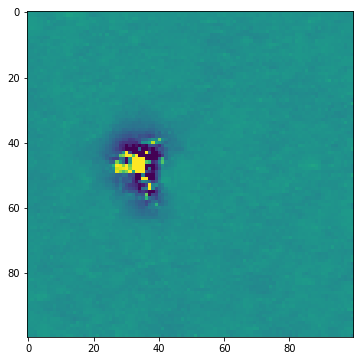

In [7]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), verbose=True)
plt.imshow(img[..., 0])

Yeah so the regularizers are freaking out, let's make them small

Iteration: 1, named_losses: [('ActivationMax Loss', 2.7210305),
 ('L-6.0 Norm Loss', 2.37625e-07),
 ('TV(2.0) Loss', 9.798626e-06)], overall loss: 2.72104048729
Iteration: 2, named_losses: [('ActivationMax Loss', 840.57007),
 ('L-6.0 Norm Loss', 1.7566939e-06),
 ('TV(2.0) Loss', 0.040433)], overall loss: 840.610473633
Iteration: 3, named_losses: [('ActivationMax Loss', 183.60637),
 ('L-6.0 Norm Loss', 2.1562694e-06),
 ('TV(2.0) Loss', 0.037751455)], overall loss: 183.644119263
Iteration: 4, named_losses: [('ActivationMax Loss', -99.217545),
 ('L-6.0 Norm Loss', 2.5625056e-06),
 ('TV(2.0) Loss', 0.040234547)], overall loss: -99.1773071289
Iteration: 5, named_losses: [('ActivationMax Loss', -263.6766),
 ('L-6.0 Norm Loss', 2.9827672e-06),
 ('TV(2.0) Loss', 0.04538056)], overall loss: -263.631225586
Iteration: 6, named_losses: [('ActivationMax Loss', -392.9043),
 ('L-6.0 Norm Loss', 3.4639343e-06),
 ('TV(2.0) Loss', 0.05342582)], overall loss: -392.850860596
Iteration: 7, named_losses: [(

Iteration: 56, named_losses: [('ActivationMax Loss', -3648.488),
 ('L-6.0 Norm Loss', 1.641911e-05),
 ('TV(2.0) Loss', 1.175467)], overall loss: -3647.3125
Iteration: 57, named_losses: [('ActivationMax Loss', -3719.4736),
 ('L-6.0 Norm Loss', 1.6657868e-05),
 ('TV(2.0) Loss', 1.2131379)], overall loss: -3718.26049805
Iteration: 58, named_losses: [('ActivationMax Loss', -3776.0955),
 ('L-6.0 Norm Loss', 1.6893637e-05),
 ('TV(2.0) Loss', 1.2509)], overall loss: -3774.84448242
Iteration: 59, named_losses: [('ActivationMax Loss', -3842.3933),
 ('L-6.0 Norm Loss', 1.7121529e-05),
 ('TV(2.0) Loss', 1.2869936)], overall loss: -3841.10620117
Iteration: 60, named_losses: [('ActivationMax Loss', -3874.6672),
 ('L-6.0 Norm Loss', 1.735921e-05),
 ('TV(2.0) Loss', 1.3335431)], overall loss: -3873.33374023
Iteration: 61, named_losses: [('ActivationMax Loss', -3949.0042),
 ('L-6.0 Norm Loss', 1.7578026e-05),
 ('TV(2.0) Loss', 1.3660169)], overall loss: -3947.63818359
Iteration: 62, named_losses: [('A

Iteration: 109, named_losses: [('ActivationMax Loss', -6525.7285),
 ('L-6.0 Norm Loss', 2.8401528e-05),
 ('TV(2.0) Loss', 3.9035554)], overall loss: -6521.82519531
Iteration: 110, named_losses: [('ActivationMax Loss', -6577.1074),
 ('L-6.0 Norm Loss', 2.8640849e-05),
 ('TV(2.0) Loss', 3.9689596)], overall loss: -6573.13867188
Iteration: 111, named_losses: [('ActivationMax Loss', -6641.895),
 ('L-6.0 Norm Loss', 2.8865396e-05),
 ('TV(2.0) Loss', 4.047018)], overall loss: -6637.84814453
Iteration: 112, named_losses: [('ActivationMax Loss', -6683.367),
 ('L-6.0 Norm Loss', 2.9089038e-05),
 ('TV(2.0) Loss', 4.102197)], overall loss: -6679.26513672
Iteration: 113, named_losses: [('ActivationMax Loss', -6735.1294),
 ('L-6.0 Norm Loss', 2.9290086e-05),
 ('TV(2.0) Loss', 4.1644316)], overall loss: -6730.96484375
Iteration: 114, named_losses: [('ActivationMax Loss', -6787.551),
 ('L-6.0 Norm Loss', 2.9558967e-05),
 ('TV(2.0) Loss', 4.259027)], overall loss: -6783.29199219
Iteration: 115, named_

Iteration: 161, named_losses: [('ActivationMax Loss', -9342.294),
 ('L-6.0 Norm Loss', 4.0274543e-05),
 ('TV(2.0) Loss', 8.175518)], overall loss: -9334.11816406
Iteration: 162, named_losses: [('ActivationMax Loss', -9375.496),
 ('L-6.0 Norm Loss', 4.0535255e-05),
 ('TV(2.0) Loss', 8.301998)], overall loss: -9367.19433594
Iteration: 163, named_losses: [('ActivationMax Loss', -9440.964),
 ('L-6.0 Norm Loss', 4.0750892e-05),
 ('TV(2.0) Loss', 8.3909025)], overall loss: -9432.57324219
Iteration: 164, named_losses: [('ActivationMax Loss', -9472.253),
 ('L-6.0 Norm Loss', 4.0957006e-05),
 ('TV(2.0) Loss', 8.461325)], overall loss: -9463.79199219
Iteration: 165, named_losses: [('ActivationMax Loss', -9537.665),
 ('L-6.0 Norm Loss', 4.1156993e-05),
 ('TV(2.0) Loss', 8.554663)], overall loss: -9529.11035156
Iteration: 166, named_losses: [('ActivationMax Loss', -9568.756),
 ('L-6.0 Norm Loss', 4.1391802e-05),
 ('TV(2.0) Loss', 8.647542)], overall loss: -9560.10839844
Iteration: 167, named_losse

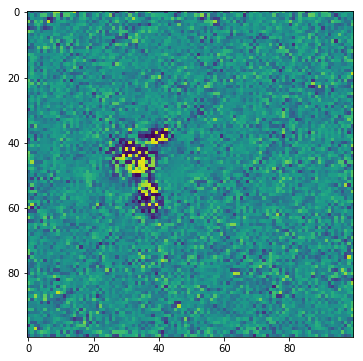

In [60]:
img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.),
                           tv_weight=1e-3, lp_norm_weight=1e-3, verbose=True)
plt.imshow(img[..., 0])

Ok they're not giving huge losses anymore but the image doesn't look much different :|

Iterating across different tv and lp weights:

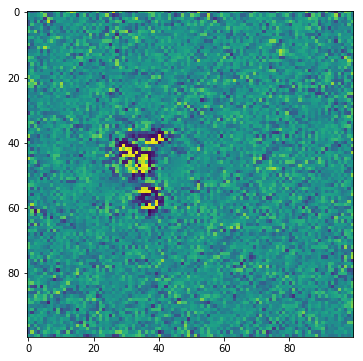

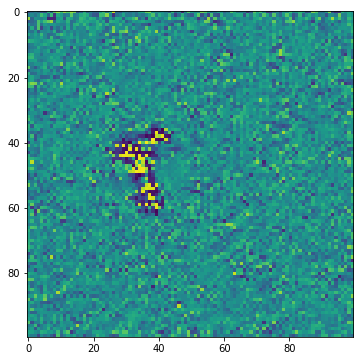

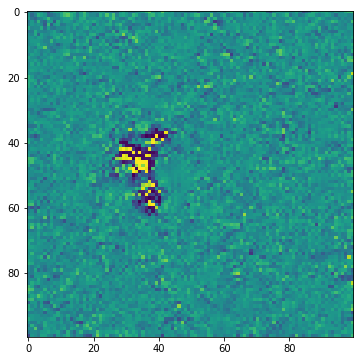

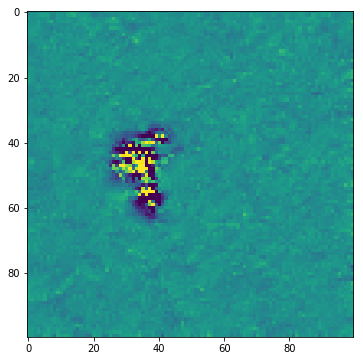

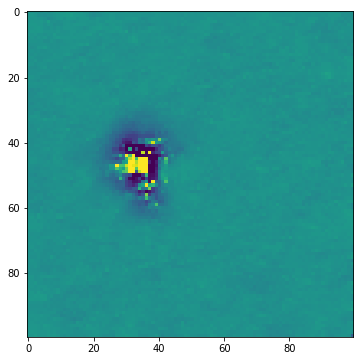

In [9]:
for tv_weight in [1e-3, 1e-2, 1e-1, 1, 10]:
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                               tv_weight=tv_weight, lp_norm_weight=0.)
    plt.figure()
    plt.imshow(img[..., 0])

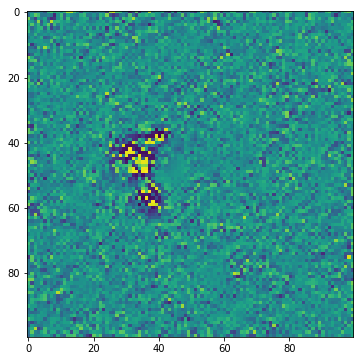

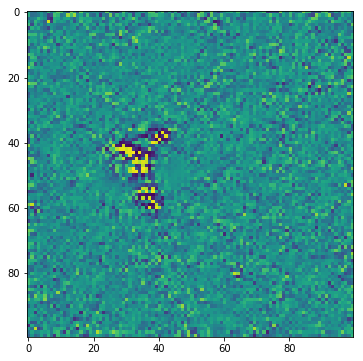

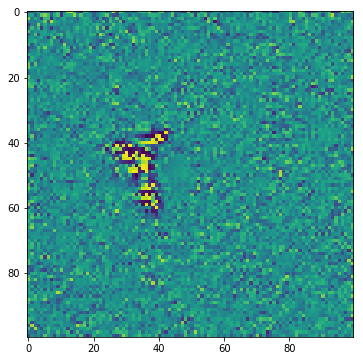

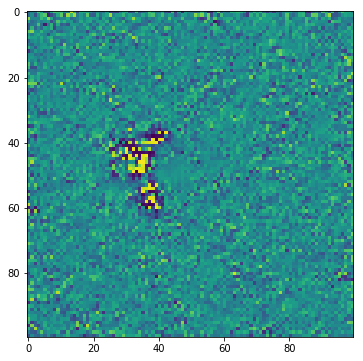

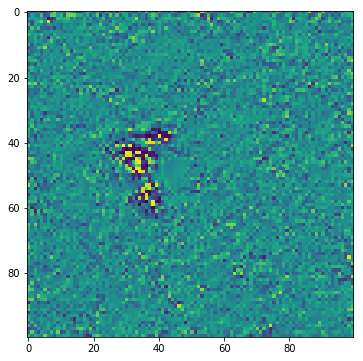

In [30]:
for lp_weight in [1e-3, 1e-2, 1e-1, 1, 10]:
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx, input_range=(0., 1.), 
                               tv_weight=0., lp_norm_weight=lp_weight)
    plt.figure()
    plt.imshow(img[..., 0])

Not really helpful...

Here's the plots for each class with regularizer weights set to 0

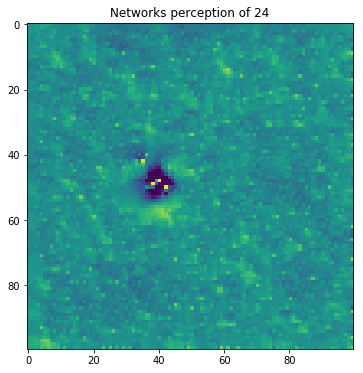

In [73]:
for output_idx in np.arange(n_classes):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    # plt.figure()
    plt.title('Networks perception of {}'.format(output_idx))
    plt.imshow(img[..., 0])

So these are kinda interesting but still don't seem interpretive

As a sanity check, let's see how these classifications compare to the original clusters

In [ ]:
x_train_pred = model.predict(x_train)
x_test_pred = model.predict(x_test)

In [ ]:
# generate spin and inclination labels for these points
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, y_data, test_size=0.25, random_state=42)

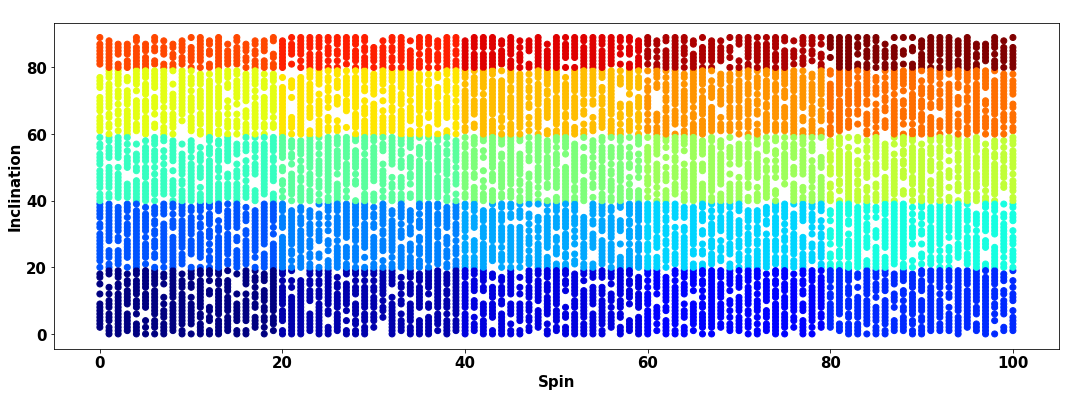

In [58]:
plt.scatter(y_train2[:,0], y_train2[:,1], c=np.argmax(y_train,axis=1),cmap='jet')#sns.color_palette("Set2", n_colors=10))
plt.title("Kmeans Clustering on 2D Encoding, K=10",fontweight='extra bold',fontsize=20,color='w')
plt.xlabel('Spin',fontweight='extra bold',fontsize=15,color='black')
plt.ylabel('Inclination',fontweight='extra bold',fontsize=15,color='black')
plt.xticks(fontweight='extra bold',fontsize=15,color='black')
plt.yticks(fontweight='extra bold',fontsize=15,color='black')
plt.title("Train Classification")
plt.show()

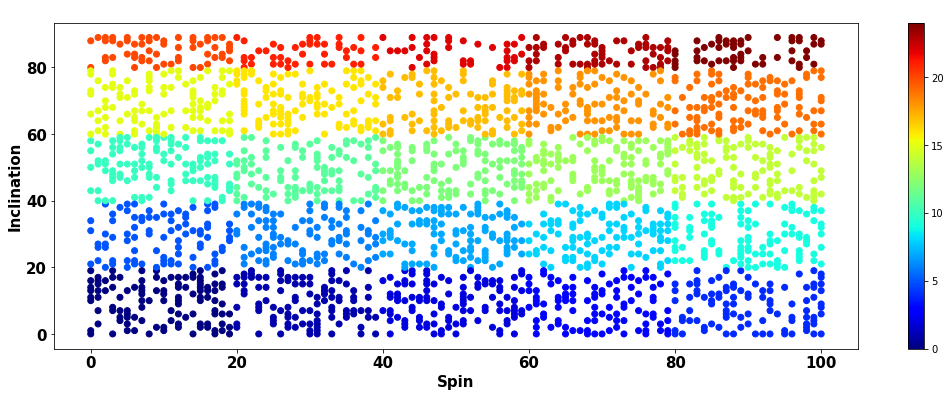

In [59]:
plt.scatter(y_test2[:,0], y_test2[:,1], c=np.argmax(y_test,axis=1),cmap='jet')#sns.color_palette("Set2", n_colors=10))
plt.title("Kmeans Clustering on 2D Encoding, K=10",fontweight='extra bold',fontsize=20,color='w')
plt.xlabel('Spin',fontweight='extra bold',fontsize=15,color='black')
plt.ylabel('Inclination',fontweight='extra bold',fontsize=15,color='black')
plt.xticks(fontweight='extra bold',fontsize=15,color='black')
plt.yticks(fontweight='extra bold',fontsize=15,color='black')
plt.colorbar()
plt.title("Test Classification")
plt.show()

So the network is definitely learning the classes well

What else could be the issue
